In [1]:
"""
trying to run bandits and see the performance of the estimator.

I want to see the failure of the maximum estimator.
Lets set T = sqrt(K) and see if it fails.
"""

using Infiltrator

include("./KjBandits.jl")
using ProgressMeter


### Settings

In [96]:
function problem_factory(
        problem_name::String, σ²::Real, seed::UInt32=987; K=-1, alpha=1.0, Delta=0.1)
    if  problem_name == "linear"
        problem = Bandit(collect(0.9:-0.1:0.0), σ², seed)
    elseif     problem_name == "linear_K100"
        problem = Bandit(collect(LinRange(1,0,100)), σ², seed)
    elseif     problem_name == "linear_K20"
        problem = Bandit(collect(LinRange(1,0,20)), σ², seed)
    elseif problem_name == "linear_K2"
        problem = Bandit([0.9,0.5], σ², seed)
    elseif problem_name == "linear_K2_custom"
        problem = Bandit([0.9,0.3], σ², seed)
    elseif problem_name == "linear_any_K"
        mu = collect(range(start=0, length=K, step=-Delta))
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "poly_K20"
        Delta_ary = ((1:20) ./ 20) .^ alpha
        mu = -Delta_ary
        mu[1] = 0.0
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "equal_K20"
        Delta_ary = Delta*ones(20)
        mu = -Delta_ary
        mu[1] = 0.0
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "equal"
#        Delta_ary = (.1*2)*ones(K) 
        Delta_ary = (.1*16)*ones(K) 
        mu = -Delta_ary
        mu[1] = 0.0
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "allbest"
        mu = zeros(K)
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "alpha_frac_single_gap"
        alphaK = Int(floor(0.7*K))
        Delta_ary = (.1*16)*ones(K) 
        mu = -Delta_ary
        for i in 1:alphaK
            mu[i] = 0.0
        end
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "all_best_one_odd"
        mu = zeros(K)
        mu[K] = -.1*16
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "linear_any_K_alpha_frac"
        alphaK = Int(floor(0.7*K))
        mu = collect(range(start=0, length=K, step=-Delta))
        for i in alphaK:K
            mu[i] -= 5.0
        end
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "randomized"
        tmp = rand(MersenneTwister(111), K)
        mu = (tmp .* 2.0) .- 2.0
        mu[1] = 0.0
        problem = Bandit(mu, σ², seed)
    end
    problem
end

function estimator_factory(name, σ², mu=Float64[], seed=123)
    if (name == "avg")
        est = Average()
    elseif name == "topavg"
        est = TopAverage()
    elseif name == "max"
        est = Max()
    elseif name == "weighted_100"
        est = Weighted(σ², 100, seed)
    elseif name == "weightedms"
        est = WeightedMs(σ²)
    elseif name == "weightedms-gen"
        est = WeightedMsGen(σ²,3)
    elseif name == "weightedms_4"
        est = WeightedMs(σ²,4)
    elseif name == "naiveoracle"
        est = NaiveOracle(mu)
    elseif name == "haver"
        est = Haver(σ²,0.05) # 0.01, 0.05, 0.10
    else
        @error "value error"
    end
    est
end


function algo_factory(algo_name::String, problem::Bandit, seed)
    if algo_name == "ucb"
        algo = Ucb(problem.K, problem.σ², seed=seed)
    elseif algo_name == "sr"
        algo = Rejects(problem.K, seed)
    elseif algo_name == "uniform"
        algo = Uniform(problem.K, seed)
    else
        @error "value error"
    end
    algo
end


algo_factory (generic function with 1 method)

### All-best

In [102]:
opt = (σ² = (1.0)^2, 
       dataseed=313, #123
       algoseed=789,
       N = 100, # 20, #50, #100
       n_trials = 200, #50, #1000, # 200
       algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
       problem_name = "allbest", #"equal", "allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
       K_ary = 2 .^ (3:11), # 3:8, 3:10
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
# estimator_names = ["topavg", "avg", "max", "haver"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.K_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_K in eachindex(opt.K_ary)
        global problem, algo
        K = opt.K_ary[i_K]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=K, alpha=NaN, Delta=NaN)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        # T = convert(Int64, ceil(K^(1.5))) # 1.5 , 2.0
        T = opt.N*K
        for t in 1:T
            i_t = next_arm(algo)
            reward = pull(problem, i_t)
            update!(algo, i_t, reward)
        end

        for i in eachindex(estimators)
            hatvalues[i_try, i_K, i] = estimate_value(estimators[i], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
mae = meansqueeze(abs.(hatvalues), 1)


estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
opt = (σ² = 1.0, dataseed = 313, algoseed = 789, N = 100, n_trials = 200, algo_name = "uniform", problem_name = "allbest", K_ary = [8, 16, 32, 64, 128, 256, 512, 1024, 2048])


Progress:  30%|████████████▏                            |  ETA: 0:04:14

LoadError: InterruptException:

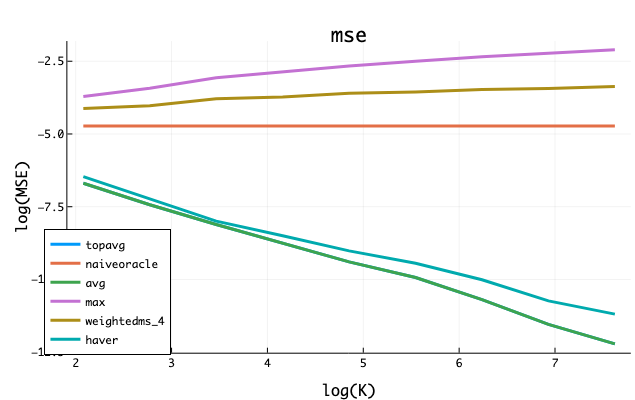

In [9]:
using Plots
plotly()

x = opt.K_ary
i = 1; plot(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="log(MSE)", legend=:bottomleft)  
title!("mse")

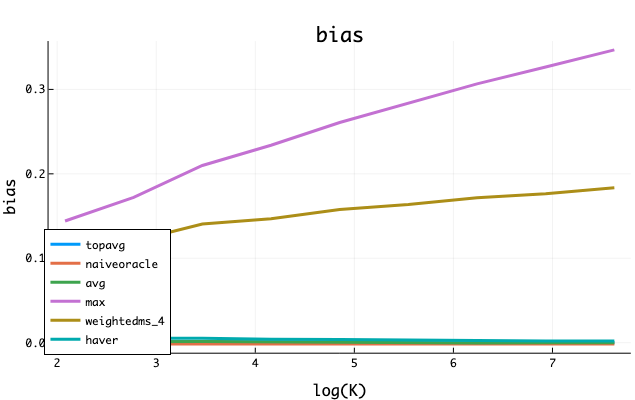

In [10]:
x = opt.K_ary
i = 1; plot(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 4; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="bias", legend=:bottomleft)  
title!("bias")

### Alpha-fraction-single-gap, alpha = 0.6

In [101]:
opt = (σ² = (1.0)^2, 
       dataseed=313, #123
       algoseed=789,
       N = 100, # 20, #50, #100
       n_trials = 200, #50, #1000, # 200
       algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
       problem_name = "alpha_frac_single_gap", #"equal", "allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
       K_ary = 2 .^ (3:11), # 3:8, 3:10
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
# estimator_names = ["topavg", "avg", "max", "haver"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.K_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_K in eachindex(opt.K_ary)
        global problem, algo
        K = opt.K_ary[i_K]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=K, alpha=NaN, Delta=NaN)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        # T = convert(Int64, ceil(K^(1.5))) # 1.5 , 2.0
        T = opt.N*K
        for t in 1:T
            i_t = next_arm(algo)
            reward = pull(problem, i_t)
            update!(algo, i_t, reward)
        end

        for i in eachindex(estimators)
            hatvalues[i_try, i_K, i] = estimate_value(estimators[i], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
mae = meansqueeze(abs.(hatvalues), 1)


estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
opt = (σ² = 1.0, dataseed = 313, algoseed = 789, N = 100, n_trials = 200, algo_name = "uniform", problem_name = "alpha_frac_single_gap", K_ary = [8, 16, 32, 64, 128, 256, 512, 1024, 2048])


Progress:   2%|█                                        |  ETA: 0:05:29

LoadError: InterruptException:

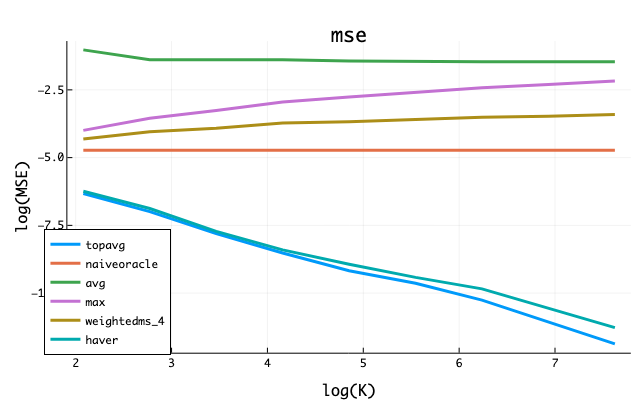

In [13]:
x = opt.K_ary
i = 1; plot(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="log(MSE)", legend=:bottomleft)  
title!("mse")

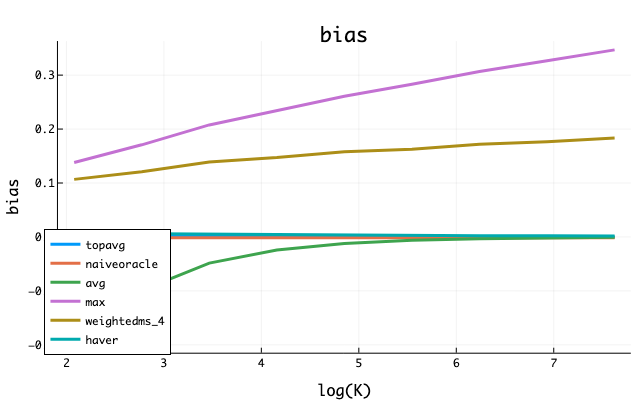

In [19]:
x = opt.K_ary
i = 1; plot(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 4; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="bias", legend=:bottomleft)  
title!("bias")

### All-best-one-odd

In [16]:
opt = (σ² = (1.0)^2, 
       dataseed=313, #123
       algoseed=789,
       N = 100, # 20, #50, #100
       n_trials = 200, #50, #1000, # 200
       algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
       problem_name = "all_best_one_odd", #"equal", "allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
       K_ary = 2 .^ (3:11), # 3:8, 3:10
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
# estimator_names = ["topavg", "avg", "max", "haver"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.K_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_K in eachindex(opt.K_ary)
        global problem, algo
        K = opt.K_ary[i_K]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=K, alpha=NaN, Delta=NaN)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        # T = convert(Int64, ceil(K^(1.5))) # 1.5 , 2.0
        T = opt.N*K
        for t in 1:T
            i_t = next_arm(algo)
            reward = pull(problem, i_t)
            update!(algo, i_t, reward)
        end

        for i in eachindex(estimators)
            hatvalues[i_try, i_K, i] = estimate_value(estimators[i], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
mae = meansqueeze(abs.(hatvalues), 1)


estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
opt = (σ² = 1.0, dataseed = 313, algoseed = 789, N = 100, n_trials = 200, algo_name = "uniform", problem_name = "all_best_one_odd", K_ary = [8, 16, 32, 64, 128, 256, 512, 1024, 2048])


Progress: 100%|█████████████████████████████████████████| Time: 0:05:44


9×6 Matrix{Float64}:
 0.0298246   0.0760537  0.198241    0.13799   0.107395  0.0316099
 0.0193911   0.0760537  0.0989968   0.170793  0.120692  0.0207751
 0.0140783   0.0760537  0.0485762   0.207666  0.139102  0.0149922
 0.00990145  0.0760537  0.0243694   0.233665  0.147086  0.0112812
 0.00710712  0.0760537  0.0130192   0.260818  0.158039  0.00859318
 0.00536183  0.0760537  0.00777253  0.283202  0.162626  0.00647526
 0.00365197  0.0760537  0.00476413  0.306593  0.171675  0.0049594
 0.00246327  0.0760537  0.00279922  0.326608  0.176506  0.00352223
 0.00178107  0.0760537  0.00187277  0.346839  0.183654  0.00275914

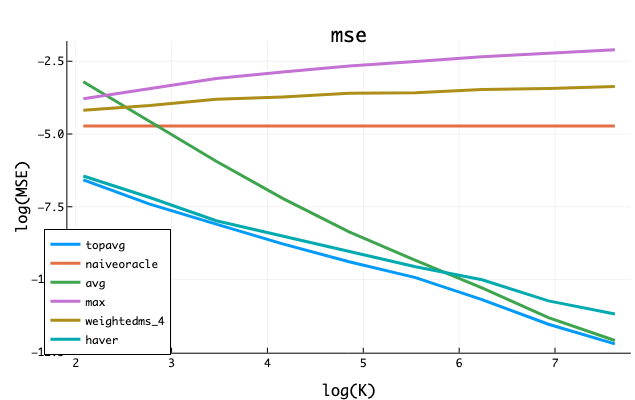

In [18]:
x = opt.K_ary
i = 1; plot(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="log(MSE)", legend=:bottomleft)  
title!("mse")

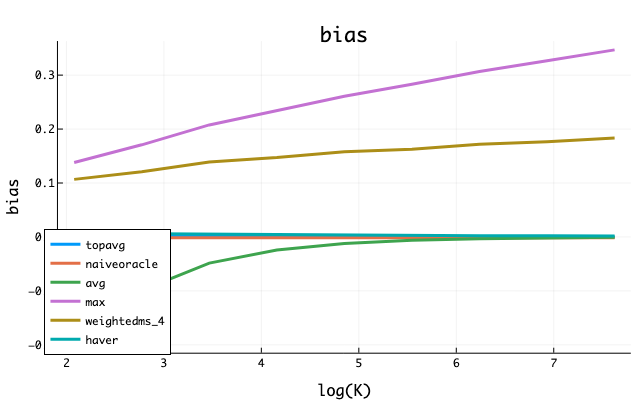

In [20]:
x = opt.K_ary
i = 1; plot(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 4; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="bias", legend=:bottomleft)  
title!("bias")

### Linear 

In [52]:
opt = (σ² = (1.0)^2, 
       dataseed=313, #123
       algoseed=789,
       N = 100, # 20, #50, #100
       n_trials = 200, #50, #1000, # 200
       algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
       problem_name = "linear_any_K", #"equal", #"allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
       K_ary = 2 .^ (3:11), # 3:8, 3:10
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
# estimator_names = ["topavg", "avg", "max", "haver"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.K_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_K in eachindex(opt.K_ary)
        global problem, algo
        K = opt.K_ary[i_K]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=K, alpha=NaN, Delta=0.2)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        # T = convert(Int64, ceil(K^(1.5))) # 1.5 , 2.0
        T = opt.N*K
        for t in 1:T
            i_t = next_arm(algo)
            reward = pull(problem, i_t)
            update!(algo, i_t, reward)
        end

        for i in eachindex(estimators)
            hatvalues[i_try, i_K, i] = estimate_value(estimators[i], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
mae = meansqueeze(abs.(hatvalues), 1)


estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
opt = (σ² = 1.0, dataseed = 313, algoseed = 789, N = 100, n_trials = 200, algo_name = "uniform", problem_name = "linear_any_K", K_ary = [8, 16, 32, 64, 128, 256, 512, 1024, 2048])


Progress: 100%|█████████████████████████████████████████| Time: 0:05:58


9×6 Matrix{Float64}:
 0.222394  0.0760537    0.698241  0.0727438  0.075711  0.139018
 0.26538   0.0760537    1.499     0.0727438  0.075711  0.147052
 0.30794   0.0760537    3.09848   0.0727438  0.075711  0.160696
 0.341452  0.0760537    6.29911   0.0727438  0.075711  0.173402
 0.373612  0.0760537   12.6997    0.0727438  0.075711  0.186178
 0.399187  0.0760537   25.5       0.0727438  0.075711  0.199349
 0.432103  0.0760537   51.1003    0.0727438  0.075711  0.213446
 0.464429  0.0760537  102.3       0.0727438  0.075711  0.223206
 0.489053  0.0760537  204.7       0.0727438  0.075711  0.23694

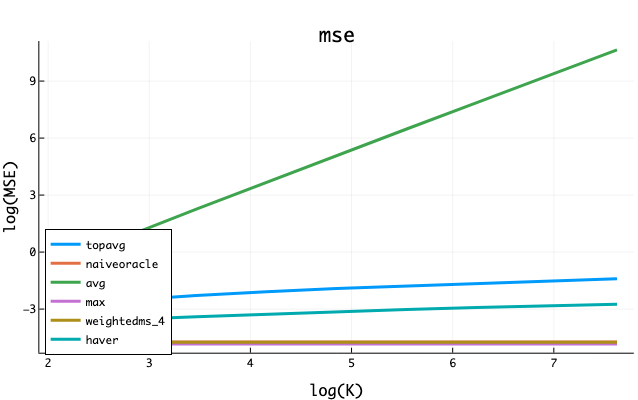

In [66]:
x = opt.K_ary
i = 1; plot(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="log(MSE)", legend=:bottomleft)  
title!("mse")

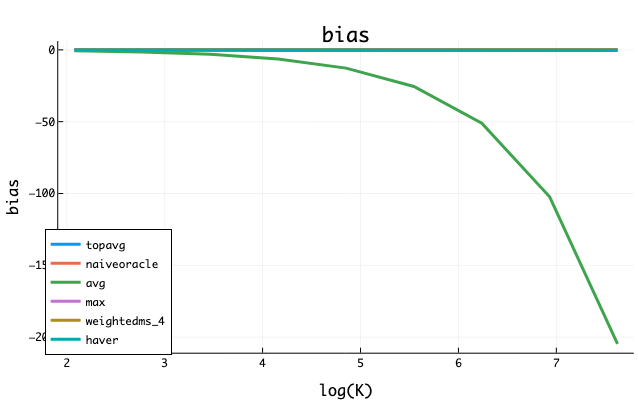

In [65]:
x = opt.K_ary
i = 1; plot(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 4; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="bias", legend=:bottomleft)  
title!("bias")

### Randomized

In [84]:
opt = (σ² = (1.0)^2, 
       dataseed=313, #123
       algoseed=789,
       N = 100, # 20, #50, #100
       n_trials = 200, #50, #1000, # 200
       algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
       problem_name = "randomized", #"equal", #"allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
       K_ary = 2 .^ (3:11), # 3:8, 3:10
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
# estimator_names = ["topavg", "avg", "max", "haver"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.K_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_K in eachindex(opt.K_ary)
        global problem, algo
        K = opt.K_ary[i_K]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=K, alpha=NaN, Delta=0.2)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        # T = convert(Int64, ceil(K^(1.5))) # 1.5 , 2.0
        T = opt.N*K
        for t in 1:T
            i_t = next_arm(algo)
            reward = pull(problem, i_t)
            update!(algo, i_t, reward)
        end

        for i in eachindex(estimators)
            hatvalues[i_try, i_K, i] = estimate_value(estimators[i], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
# mae = meansqueeze(abs.(hatvalues), 1)

estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
opt = (σ² = 1.0, dataseed = 313, algoseed = 789, N = 100, n_trials = 200, algo_name = "uniform", problem_name = "randomized", K_ary = [8, 16, 32, 64, 128, 256, 512, 1024, 2048])


Progress: 100%|█████████████████████████████████████████| Time: 0:06:04


9×6 Matrix{Float64}:
 0.141945  0.0760537  0.837151  0.0667809  0.067284   0.116918
 0.16323   0.0760537  0.799375  0.0845319  0.0680836  0.0899592
 0.217523  0.0760537  0.774294  0.0905229  0.0669475  0.12423
 0.312109  0.0760537  0.82893   0.091459   0.064726   0.163102
 0.360741  0.0760537  0.974475  0.102457   0.0634535  0.176492
 0.36305   0.0760537  0.978213  0.13839    0.0748456  0.164931
 0.409829  0.0760537  1.01162   0.157422   0.0784195  0.175871
 0.433466  0.0760537  1.01681   0.173891   0.0781873  0.195326
 0.45184   0.0760537  1.01318   0.202963   0.0928065  0.191168

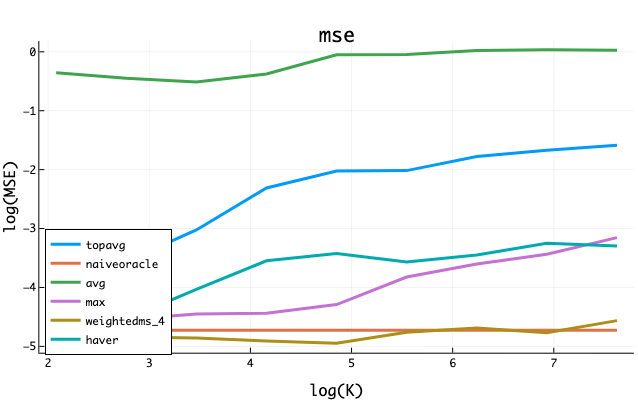

In [85]:
x = opt.K_ary
i = 1; plot(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="log(MSE)", legend=:bottomleft)  
title!("mse")

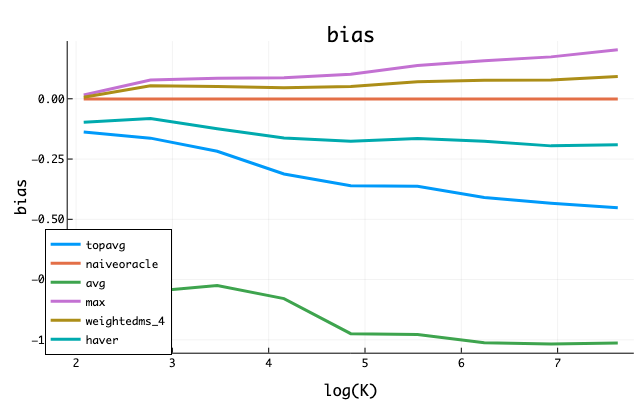

In [86]:
x = opt.K_ary
i = 1; plot(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 4; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="bias", legend=:bottomleft)  
title!("bias")

### Linear Alpha-fraction

In [97]:
opt = (σ² = (1.0)^2, 
       dataseed=313, #123
       algoseed=789,
       N = 100, # 20, #50, #100
       n_trials = 200, #50, #1000, # 200
       algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
       problem_name = "linear_any_K_alpha_frac", #"equal", #"allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
       K_ary = 2 .^ (3:11), # 3:8, 3:10
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
# estimator_names = ["topavg", "avg", "max", "haver"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.K_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_K in eachindex(opt.K_ary)
        global problem, algo
        K = opt.K_ary[i_K]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=K, alpha=NaN, Delta=0.2)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        # T = convert(Int64, ceil(K^(1.5))) # 1.5 , 2.0
        T = opt.N*K
        for t in 1:T
            i_t = next_arm(algo)
            reward = pull(problem, i_t)
            update!(algo, i_t, reward)
        end

        for i in eachindex(estimators)
            hatvalues[i_try, i_K, i] = estimate_value(estimators[i], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
# mae = meansqueeze(abs.(hatvalues), 1)

estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
opt = (σ² = 1.0, dataseed = 313, algoseed = 789, N = 100, n_trials = 200, algo_name = "uniform", problem_name = "linear_any_K_alpha_frac", K_ary = [8, 16, 32, 64, 128, 256, 512, 1024, 2048])


Progress: 100%|█████████████████████████████████████████| Time: 0:05:33


9×6 Matrix{Float64}:
 0.0553071  0.00883898     10.23    0.00797569  0.00867885  0.0260449
 0.0788309  0.00883898     11.3844  0.00797569  0.00867985  0.028714
 0.101353   0.00883898     23.206   0.00797569  0.00867985  0.0334668
 0.124244   0.00883898     63.0395  0.00797569  0.00867985  0.0380965
 0.146314   0.00883898    203.412   0.00797569  0.00867985  0.0426488
 0.166908   0.00883898    730.266   0.00797569  0.00867985  0.0485344
 0.194761   0.00883898   2768.23    0.00797569  0.00867985  0.0538953
 0.22307    0.00883898  10776.3     0.00797569  0.00867985  0.0582055
 0.246263   0.00883898  42520.1     0.00797569  0.00867985  0.0640284

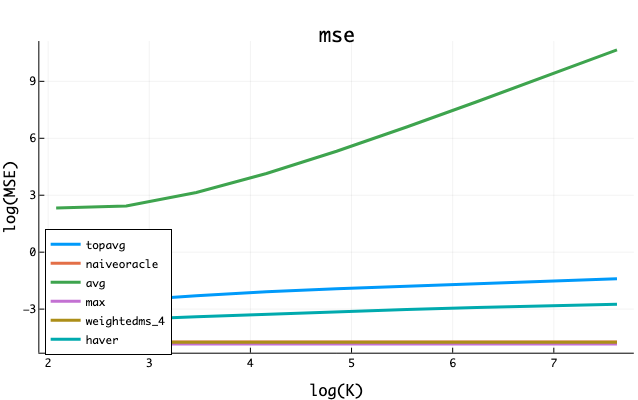

In [98]:
x = opt.K_ary
i = 1; plot(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="log(MSE)", legend=:bottomleft)  
title!("mse")

In [99]:
opt = (σ² = (1.0)^2, 
       dataseed=313, #123
       algoseed=789,
       N = 20, # 20, #50, #100
       n_trials = 200, #50, #1000, # 200
       algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
       problem_name = "linear_any_K_alpha_frac", #"equal", #"allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
       K_ary = 2 .^ (3:11), # 3:8, 3:10
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
# estimator_names = ["topavg", "avg", "max", "haver"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.K_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_K in eachindex(opt.K_ary)
        global problem, algo
        K = opt.K_ary[i_K]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=K, alpha=NaN, Delta=0.2)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        # T = convert(Int64, ceil(K^(1.5))) # 1.5 , 2.0
        T = opt.N*K
        for t in 1:T
            i_t = next_arm(algo)
            reward = pull(problem, i_t)
            update!(algo, i_t, reward)
        end

        for i in eachindex(estimators)
            hatvalues[i_try, i_K, i] = estimate_value(estimators[i], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
# mae = meansqueeze(abs.(hatvalues), 1)

estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
opt = (σ² = 1.0, dataseed = 313, algoseed = 789, N = 20, n_trials = 200, algo_name = "uniform", problem_name = "linear_any_K_alpha_frac", K_ary = [8, 16, 32, 64, 128, 256, 512, 1024, 2048])


Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


9×6 Matrix{Float64}:
 0.091926  0.0394316     10.2174  0.0322085  0.0314097  0.0720958
 0.419234  0.0394316     11.3954  0.0322085  0.0320388  0.129006
 0.541992  0.0394316     23.2062  0.0322085  0.0320388  0.151904
 0.660521  0.0394316     63.067   0.0322085  0.0320388  0.185678
 0.787759  0.0394316    203.468   0.0322085  0.0320388  0.214464
 0.919781  0.0394316    730.337   0.0322085  0.0320388  0.237946
 1.04428   0.0394316   2768.29    0.0322085  0.0320388  0.275818
 1.16773   0.0394316  10776.3     0.0322085  0.0320388  0.306652
 1.27577   0.0394316  42520.2     0.0322085  0.0320388  0.335079

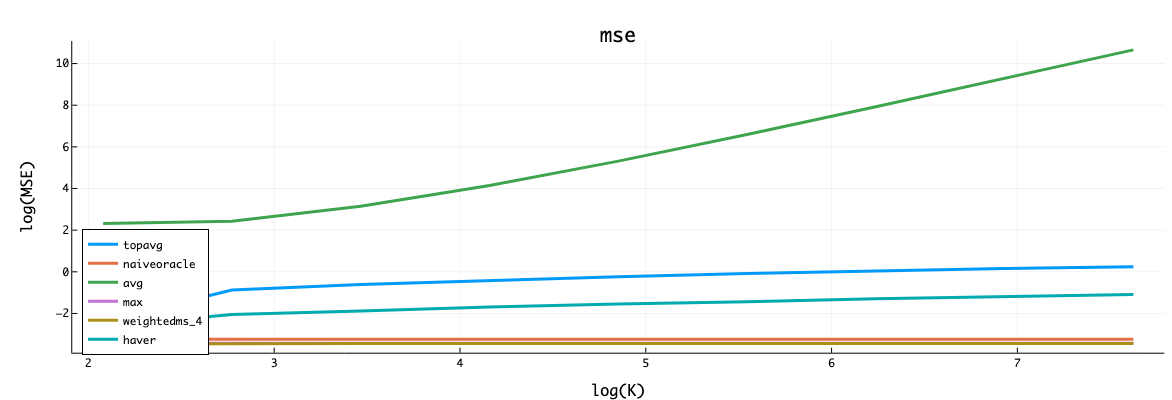

In [103]:
x = opt.K_ary
i = 1; plot(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="log(MSE)", legend=:bottomleft)  
title!("mse")

In [100]:
opt = (σ² = (1.0)^2, 
       dataseed=313, #123
       algoseed=789,
       N = 1000, # 20, #50, #100
       n_trials = 200, #50, #1000, # 200
       algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
       problem_name = "linear_any_K_alpha_frac", #"equal", #"allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
       K_ary = 2 .^ (3:11), # 3:8, 3:10
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
# estimator_names = ["topavg", "avg", "max", "haver"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.K_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_K in eachindex(opt.K_ary)
        global problem, algo
        K = opt.K_ary[i_K]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=K, alpha=NaN, Delta=0.2)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        # T = convert(Int64, ceil(K^(1.5))) # 1.5 , 2.0
        T = opt.N*K
        for t in 1:T
            i_t = next_arm(algo)
            reward = pull(problem, i_t)
            update!(algo, i_t, reward)
        end

        for i in eachindex(estimators)
            hatvalues[i_try, i_K, i] = estimate_value(estimators[i], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
# mae = meansqueeze(abs.(hatvalues), 1)

estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
opt = (σ² = 1.0, dataseed = 313, algoseed = 789, N = 1000, n_trials = 200, algo_name = "uniform", problem_name = "linear_any_K_alpha_frac", K_ary = [8, 16, 32, 64, 128, 256, 512, 1024, 2048])


Progress:  45%|██████████████████▌                      |  ETA: 0:29:03

LoadError: InterruptException:

In [ ]:
x = opt.K_ary
i = 1; plot(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="log(MSE)", legend=:bottomleft)  
title!("mse")